In [1]:
!pip install pymc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pymc as pm
import numpy as np
import pandas as pd



In [3]:
import arviz as az
import matplotlib.pyplot as plt
df = pd.read_csv('ARE_Data.csv',index_col='Date',parse_dates=True)
# df = data[['Price','Open','High','Low','Vol','Change']]
# df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
df

,Price,Open,High,Low,Vol,Change
Date,,,,,,
2023-04-13,119.54,121.31,121.64,118.56,1230000,-0.0163
2023-04-12,121.52,124.82,124.84,121.40,1000000,-0.0124
2023-04-11,123.04,124.03,124.96,122.89,1420000,-0.0079
2023-04-10,124.02,123.55,124.51,121.98,771660,-0.0030
2023-04-06,124.39,124.32,124.74,122.64,604220,0.0059
...,...,...,...,...,...,...
2017-12-07,128.17,126.94,128.30,126.39,834960,0.0104
2017-12-06,126.85,126.40,127.04,125.68,635900,0.0066
2017-12-05,126.02,129.00,129.21,125.70,1280000,-0.0233


In [4]:
az.style.use("arviz-darkgrid")
seed = sum(map(ord, "PyMC LABS - BVAR"))
rng = np.random.default_rng(seed=seed)

In [5]:
def simulate_ar(intercept, coef1, coef2, noise=1, *, warmup=10, steps=200):   
    # We sample some extra warmup steps, to let the AR process stabilize
    draws = np.zeros(warmup+steps)
    # Initialize first draws at intercept
    draws[:2] = intercept
    for step in range(2, warmup+steps):
        draws[step] = (
            intercept 
            + coef1 * draws[step-1]
            + coef2 * draws[step-2]
            + rng.normal(0, noise)
        )
    # Discard the warmup draws
    return draws[warmup:]

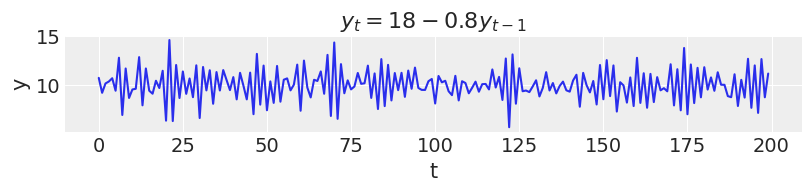

In [6]:
ar1 = simulate_ar(18, -0.8, 0)

_, ax = plt.subplots(figsize=(8, 1.8))
ax.plot(ar1)
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_title("$y_t = 18 - 0.8y_{t-1}$");

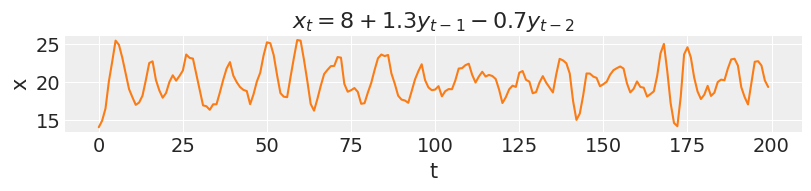

In [7]:
ar2 = simulate_ar(8, 1.3, -0.7)

_, ax = plt.subplots(figsize=(8, 1.8))
ax.plot(ar2, color="C1")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title("$x_t = 8 + 1.3y_{t-1} - 0.7y_{t-2}$");

In [8]:
def simulate_var(intercepts, coefs_yy, coefs_xy, coefs_xx, coefs_yx, noises=(1, 1), *, warmup=100, steps=200):
    draws_y = np.zeros(warmup+steps)
    draws_x = np.zeros(warmup+steps)
    draws_y[:2] = intercepts[0]
    draws_x[:2] = intercepts[1]
    for step in range(2, warmup+steps):
        draws_y[step] = (
            intercepts[0]
            + coefs_yy[0] * draws_y[step-1]
            + coefs_yy[1] * draws_y[step-2]
            + coefs_xy[0] * draws_x[step-1]
            + coefs_xy[1] * draws_x[step-2]
            + rng.normal(0, noises[0])
        )
        draws_x[step] = (
            intercepts[1]
            + coefs_xx[0] * draws_x[step-1]
            + coefs_xx[1] * draws_x[step-2]
            + coefs_yx[0] * draws_y[step-1]
            + coefs_yx[1] * draws_y[step-2]
            + rng.normal(0, noises[1])
        )
    return draws_y[warmup:], draws_x[warmup:]

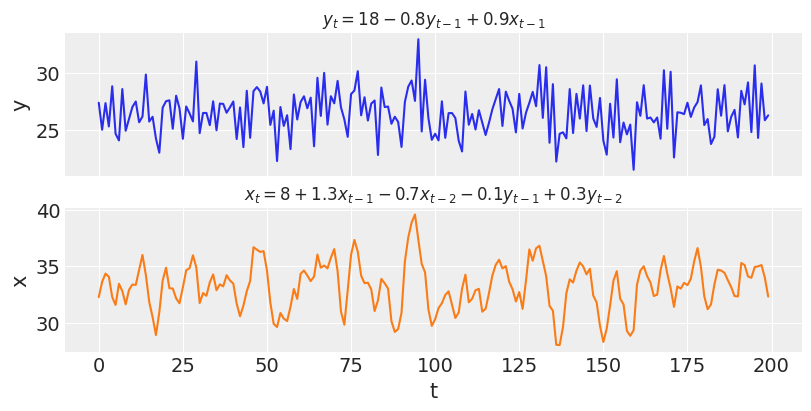

In [9]:
var_y, var_x = simulate_var(
    intercepts=(18, 8),
    coefs_yy=(-0.8, 0),
    coefs_xy=(0.9, 0),
    coefs_xx=(1.3, -0.7),
    coefs_yx=(-0.1, 0.3),
)

_, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax[0].plot(var_y)
ax[0].set_title("$y_t = 18 - 0.8y_{t-1} + 0.9x_{t-1}$", fontsize=12)
ax[0].set_ylabel("y")

ax[1].plot(var_x, color="C1")
ax[1].set_title("$x_t = 8 + 1.3x_{t-1} - 0.7x_{t-2} - 0.1y_{t-1} + 0.3y_{t-2}$", fontsize=12)
ax[1].set_ylabel("x")
ax[1].set_xlabel("t");

In [10]:
# 2. Đọc file dữ liệu và chia train test validate theo tỉ lệ 7:1:2
df=df[["Price", "Change"]]
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

data = df[:train_size] # train 
test_data = df[train_size:train_size+test_size] # test
val_data = df[train_size+test_size:] # validate

data.shape, test_data.shape, val_data.shape

((944, 2), (269, 2), (136, 2))

In [11]:
from matplotlib.colors import ColorConverter
colors = ("C0", "C1")

dark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
}

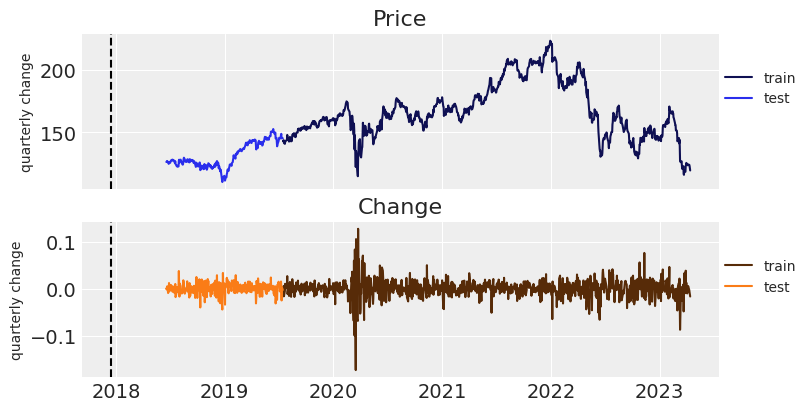

In [12]:
_, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax[0].plot(data["Price"], color=dark["C0"], label="train")
ax[0].plot(test_data["Price"], color="C0", label="test")
ax[0].set_ylabel("quarterly change", fontsize=10)
ax[0].set_title("Price")

ax[1].plot(data["Change"], color=dark["C1"], label="train")
ax[1].plot(test_data["Change"], color="C1", label="test")
ax[1].set_ylabel("quarterly change", fontsize=10)
ax[1].set_title("Change");

for axi in ax:
    axi.axvline(df.index[-10], ls="--", color="k")
    axi.legend(loc=(1, 0.5), fontsize=10)

In [13]:
lags = 2

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": ("Price", "Change"),
    "cross_vars": ("Price", "Change"),
    "time": range(len(data) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))

    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_GDPGrowth = pm.math.sum([
        pm.math.sum(lag_coefs[i, 0] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)        
    ar_TSpread = pm.math.sum([
        pm.math.sum(lag_coefs[i, 1] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)   

    # Stack autoregressive terms and add intercepts
    mean = intercept + pm.math.stack([ar_GDPGrowth, ar_TSpread], axis=-1)

    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=data[lags:], dims=("time", "vars"))

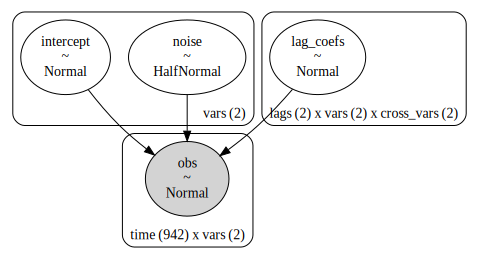

In [14]:
pm.model_to_graphviz(BVAR_model)

In [15]:
#  thực hiện quá trình lấy mẫu từ mô hình BVAR bằng phương pháp Markov Chain Monte Carlo (MCMC) 
# để xác định phân phối xác suất hậu nghiệm của các tham số trong mô hình
# trace = pm.sample(chains=4, random_seed=rng) thực hiện quá trình lấy mẫu bằng 
# cách chạy MCMC trên mô hình. chains=4 chỉ định rằng sẽ sử dụng 4 chuỗi Markov Chains 
#đồng thời để thực hiện quá trình lấy mẫu. random_seed=rng đặt giá trị hạt giống ngẫu nhiên
# (rng) để đảm bảo kết quả lấy mẫu có thể tái lặp được. Kết quả của quá trình lấy mẫu sẽ được lưu trữ trong biến trace.
with BVAR_model:
    trace = pm.sample(chains=4, random_seed=rng)

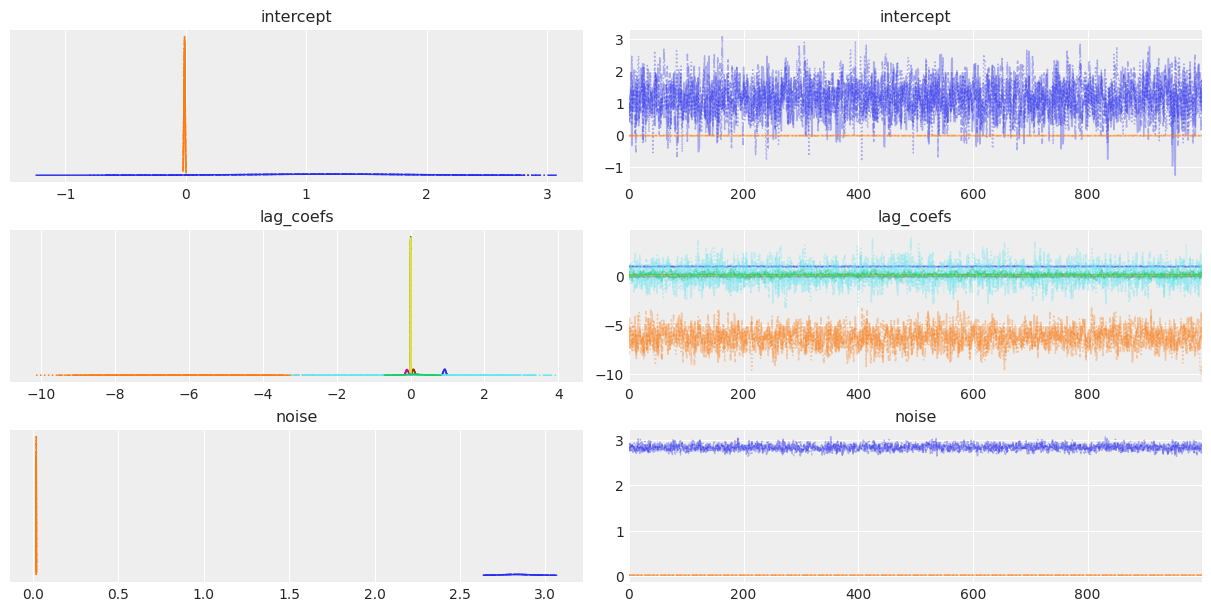

In [16]:
az.plot_trace(trace);

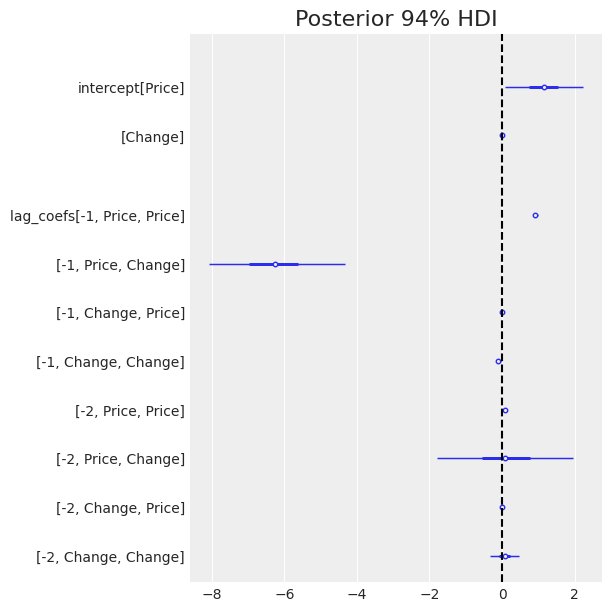

In [17]:
az.plot_forest(trace, var_names=["intercept", "lag_coefs"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI");

In [18]:
# Function that takes a single draw of parameters and forecasts n steps
def _forecast(intercept, lag_coefs, noise, forecast=10):
    len_data = len(data)
    new_draws = np.zeros((data.shape[0]+forecast, data.shape[1]))
    # Fill the new array with the observed data
    new_draws[:len_data] = data[:]
    for i in range(forecast):
        ar_Price = np.sum(lag_coefs[:, 0] * new_draws[len_data+i-lags: len_data+i])
        ar_Change = np.sum(lag_coefs[:, 1] * new_draws[len_data+i-lags: len_data+i])
        mean = intercept + np.stack([ar_Price, ar_Change])
        new_draws[len_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    new_draws[:-forecast-1] = np.nan
    return new_draws

# Vectorized forecast function to handle multiple parameter draws
forecast = np.vectorize(
    _forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

In [19]:
# Take a random subset of 100 draws from the posterior
draws = rng.integers(4000, size=100)

post = trace.posterior.stack(sample=("chain", "draw"))
intercept_draws = post["intercept"].values.T[draws]

lag_coefs_draws = post["lag_coefs"].values.T[draws].T
lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 0)

noise_draws = post["noise"].values.T[draws]

intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape

((100, 2), (100, 2, 2, 2), (100, 2))

In [20]:
# Forecast 10 quarters into the future
ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=10)
ppc_draws = np.swapaxes(ppc_draws, 0, 1)

ValueError: ignored

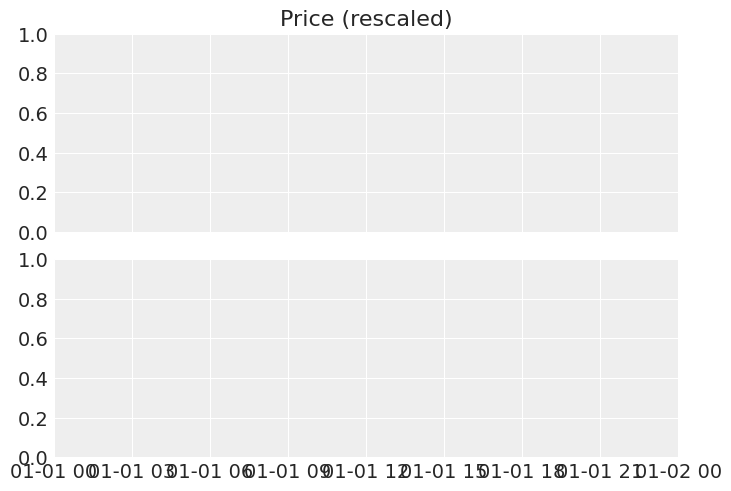

In [21]:
_, ax = plt.subplots(2, 1, sharex=True)

ax[0].set_title("Price (rescaled)")
ax[0].plot(df.index, ppc_draws[..., 0], color="C0", alpha=0.05)
ax[0].plot(df["Price"], color="k", label="observed")
ax[0].plot([], color="C0", label="forecast")

ax[1].set_title("Change %")
ax[1].plot(df.index, ppc_draws[..., 1], color="C1", alpha=0.05)
ax[1].plot(df["Change"], color="k", label="observed")
ax[1].plot([], color="C1", label="forecast")


for axi in ax:
    axi.axvline(test_data.index[0], ls="--", color="k")
    axi.legend(fontsize=10, loc=(1, .4))
    axi.set_ylabel("quartely change", fontsize=12)